## implementation of a stable diffusion process

### https://github.com/cabannas/Introduction-to-Diffusion-Models/blob/main/Paper1_trainingequations.ipynb

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
import tqdm

In [11]:
print(make_swiss_roll().__doc__)

Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.


In [56]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [57]:
n_samples = 10000
data, _ = make_swiss_roll(n_samples)

data = data[:, [2, 0]] / 10
data = data * np.array([1,-1])

(-2.0, 2.0)

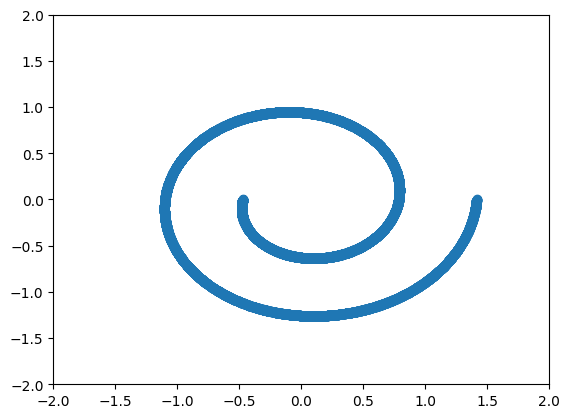

In [58]:
plt.scatter(data[:, 0], data[:, 1])
plt.xlim([-2,2])
plt.ylim([-2,2])

In [59]:
def forward_process(data, T, betas):
    for t in range(T):
        beta_t = betas[t]
        mean = data * torch.sqrt(1 - beta_t)
        std = torch.sqrt(beta_t)
        # sample from q(x_t | x_{t-1})
        data = mean + torch.randn_like(data) * std # sampling data from N(mean, std)
    return data

In [60]:
T = 40
betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
xT = forward_process(torch.from_numpy(data), T, betas)
xT.shape

torch.Size([10000, 2])

(-4.0, 4.0)

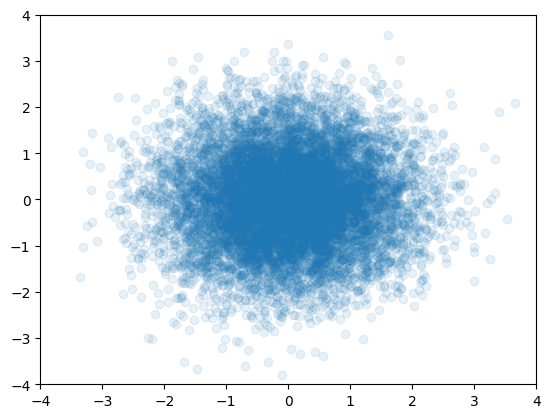

In [61]:
plt.scatter(xT[:, 0], xT[:, 1], alpha=0.1)
plt.xlim([-4,4])
plt.ylim([-4,4])

In [62]:
def sample_batch(n_samples = 10000, device="cpu"):
    data, _ = make_swiss_roll(n_samples)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1,-1])
    return torch.from_numpy(data)

def display_data(xT):
    plt.scatter(xT[:, 0], xT[:, 1], alpha=0.1)
    plt.xlim([-2,2])
    plt.ylim([-2,2])

def display_steps_data(x0, steps=20):
    fig = plt.figure(figsize=(10,3))
    data = [x0, model.forward_process(x0, steps), model.forward_process(x0, steps * 2)]
    for i in range(3):
        plt.subplot(1, 3, 1+i)        
        plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1)
        plt.xlim([-2,2])
        plt.ylim([-2,2])
        if i == 0: plt.title('t=0')
        if i == 1: plt.title('t=20')
        if i == 2: plt.title('t=40')

def dispay_reverse_steps_data(samples):
    fig = plt.figure(figsize=(10,3))
    time_steps = [0, 20, 40]    
    for i in range(3):
        plt.subplot(2, 3, 4+i)        
        plt.scatter(samples[i][:, 0].data.numpy(), samples[i][:, 1].data.numpy(), alpha=0.1, c='red')
        plt.xlim([-2,2])
        plt.ylim([-2,2])
        if i == 0: plt.title('t=0')
        if i == 1: plt.title('t=20')
        if i == 2: plt.title('t=40')

In [63]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, N=40, data_dim=2, hidden_dim=128):
        super(MLP, self).__init__()
        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim, hidden_dim),
                                         )
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                           nn.ReLU(),
                                           nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])

    def forward(self, x, t):
        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
        mean, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)
        return mean, std
        

In [64]:
model = MLP()
t = 5
x = torch.randn((64, 2))
model(x, t)

(tensor([[-0.0244, -0.1493],
         [-0.0688, -0.0824],
         [-0.0708, -0.0923],
         [-0.0417, -0.1066],
         [ 0.0563, -0.1186],
         [-0.1318, -0.0879],
         [-0.0163, -0.1270],
         [-0.0487, -0.1022],
         [-0.0057, -0.1531],
         [-0.0846, -0.0888],
         [-0.0086, -0.1676],
         [-0.0240, -0.1486],
         [-0.0039, -0.0906],
         [-0.0396, -0.0840],
         [-0.1035, -0.0918],
         [-0.0738, -0.0882],
         [-0.0114, -0.1757],
         [-0.0650, -0.0919],
         [-0.0337, -0.1109],
         [-0.0794, -0.1021],
         [-0.0110, -0.1573],
         [ 0.0155, -0.1276],
         [-0.0290, -0.1430],
         [-0.0978, -0.0939],
         [-0.1321, -0.1133],
         [-0.1080, -0.1100],
         [-0.0643, -0.1130],
         [ 0.0035, -0.1165],
         [-0.0944, -0.0864],
         [-0.0013, -0.0942],
         [-0.1024, -0.0880],
         [-0.0740, -0.1063],
         [-0.0144, -0.1362],
         [-0.1084, -0.1075],
         [ 0.0

In [65]:
import torch.nn as nn

class DiffusionModel():
    def __init__(self, T, model: nn.Module, device, dim=2):
        self.betas = (torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5).to(device) # scaling data
        self.alphas = 1-self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0).to(device)

        self.T = T
        self.model = model
        self.dim = dim
        self.device = device


    def forward_process(self, x0, t):

        # param t: Number of diffusion steps
        # param x0: data

        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, 'T should be lower or equal than {self.T}'

        t = t - 1 # Because we start indexing at 0

        mu = torch.sqrt(self.alphas_bar[t].to(self.device)) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        xt = mu + epsilon * std # data ~ N(mu, std)

        std_q = torch.sqrt((1 - self.alphas_bar[t-1]) / (1 - self.alphas_bar[t]) * self.betas[t])
        m1 = torch.sqrt(self.alphas_bar[t-1]) * self.betas[t] / (1 - self.alphas_bar[t])
        m2 = torch.sqrt(self.alphas[t]) * (1 - self.alphas_bar[t-1]) / (1 - self.alphas_bar[t])
        mu_q = m1 * x0 + m2 * xt

        return mu_q, std_q, xt
    
    def reverse_process(self, xt, t):

        # param t: Number of diffusion steps
        # param x0: data

        assert t > 0, 't should be greater than 0'
        assert self.T <= self.T, 'T should be lower or equal than {self.T}'

        t = t - 1 # Because we start indexing at 0

        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)

        return mu, std, mu + epsilon * std # data ~ N(mu, std)
    

    def sample(self, batch_size, device):
        
        noise = torch.randn((batch_size, self.dim)).to(device)
        x = noise

        samples = [x]

        for t in range(self.T, 0, -1):

            if not t == 1:
                _, _, x = self.reverse_process(x,t) # only reverse if t greater than 1

            samples.append(x)

        return samples[::-1]
    
    def get_loss(self, x0):

        # param x0: batch [batch_size, self.dim]

        t = torch.randint(2, 40+1, (1,))
        mu_q, sigma_q, xt = self.forward_process(x0, t)
        mu_p, sigma_p, xt_minus1 = self.reverse_process(xt.float(), t)

        KL = torch.log(sigma_p) - torch.log(sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2) / (2 * sigma_p**2)
        K = - KL.mean() # should be maximized
        loss = - K # should be minimized

        return loss

In [66]:
x0 = sample_batch(5000)
n_time_steps = 40
diffusionmodel = DiffusionModel(n_time_steps)
xT = diffusionmodel.forward_process(x0, 20)

TypeError: __init__() missing 2 required positional arguments: 'model' and 'device'

In [ ]:
from tqdm import tqdm

def train(model, optimizer, batch_size, epochs):
    training_loss = []
    for epoch in tqdm(range(epochs)):
        x0 = sample_batch(128)
        loss = model.get_loss(x0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())
        if epoch % 50000 == 0:
            #plt.plot(loss.item())
            plot(model, device)
    #return training_loss

mlp_model = MLP(hidden_dim=128)
n_time_steps = 40
diffusionmodel = DiffusionModel(n_time_steps, mlp_model, "cpu")
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4)
train(diffusionmodel, optimizer, 64000, 300000)

 99%|██████████████████████████████████████████████████████████████████████▉ | 295677/300000 [1:31:21<00:46, 92.66it/s]

In [42]:
def plot(model, device):
    font_size = 14
    fig = plt.figure(figsize=(10, 6))

    N = 5_000
    x0 = sample_batch(N).to(device)
    samples = model.sample(N, device=device)

    data = [x0.cpu(), model.forward_process(x0, 20)[-1].cpu(), model.forward_process(x0, 40)[-1].cpu()]
    for i in range(3):

        plt.subplot(2, 3, 1+i)
        plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1, s=1)
        plt.xlim([-2,2])
        plt.ylim([-2,2])
        plt.gca().set_aspect('equal')

        if i == 0:
            plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize = font_size)
            plt.title(r'$t=0$', fontsize = font_size)
        elif i == 1:
            plt.title(r'$t=\frac{T}{2}$', fontsize = font_size)
        elif i == 2:
            plt.title(r'$t=T$', fontsize = font_size)

    time_steps = [0, 20, 40]

    for i in range(3):

        plt.subplot(2, 3, 4+i)
        plt.scatter(samples[time_steps[i]][:, 0].data.cpu().numpy(), samples[time_steps[i]][:, 1].data.cpu().numpy(),
                    alpha=0.1, c='r', s=1)
        plt.xlim([-2,2])
        plt.ylim([-2,2])
        plt.gca().set_aspect('equal')

        if i == 0:
            plt.ylabel(r'$p(\mathbf{x}^{(0..T)})$', fontsize = font_size)


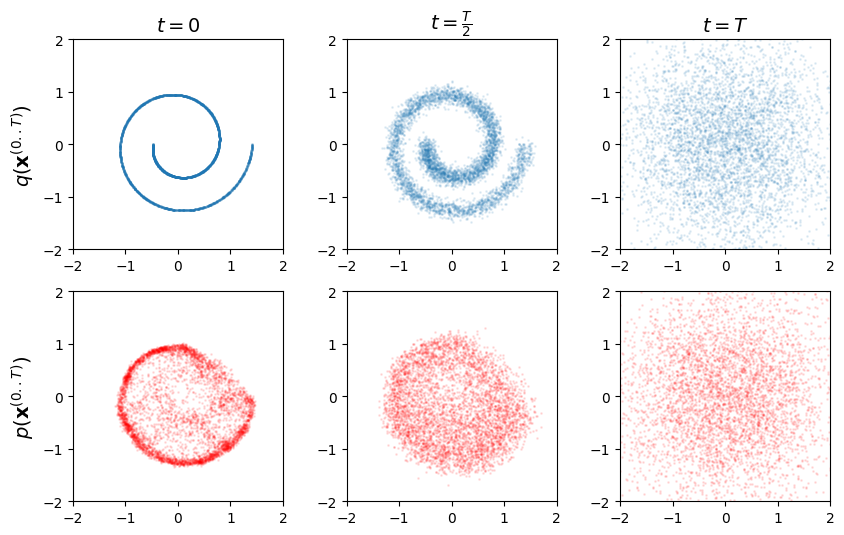

In [36]:
plot(diffusionmodel, device)

In [ ]:
samples = diffusionmod

In [ ]:
el.sample(1000)

In [ ]:
plt.scatter(samples[20][:, 0].data.numpy(), samples[20][:, 1].data.numpy())

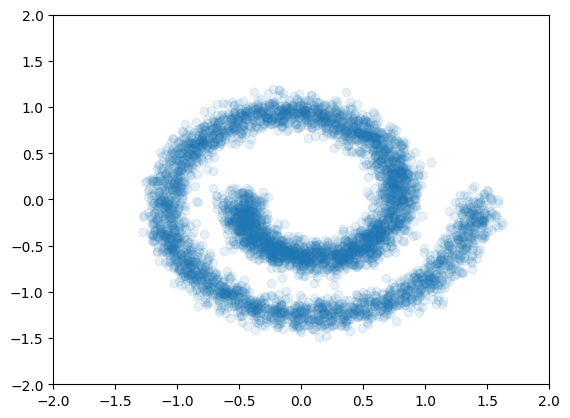

In [25]:
display_data(xT)

In [26]:
display_steps_data(xT)

AttributeError: 'MLP' object has no attribute 'forward_process'

<Figure size 1000x300 with 0 Axes>

In [ ]:
plt.scatter(xT[:, 0], xT[:, 1], alpha=0.1)
plt.xlim([-4,4])
plt.ylim([-4,4])

In [ ]:
[1, 2, 3]
1 
1 * 2 
1 * 2 * 3
[1, 1*2, 1*2*3]

In [ ]:
t = torch.tensor([1,2,3])
t_prod = torch.cumprod(t, dim=0)
print(t, t_prod)